In [1]:
import math
import cmath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.color import rgb2gray

In [2]:
# Read the image and convert colorful images to grayscale
lenna = rgb2gray(skio.imread('Lenna.png'))
dora = rgb2gray(skio.imread('dora.png'))
platform = rgb2gray(skio.imread('platform.png'))
hibiscus = skio.imread('hibiscus.png')
balloon = skio.imread('balloon.png')

In [21]:
print(len(hibiscus))

854


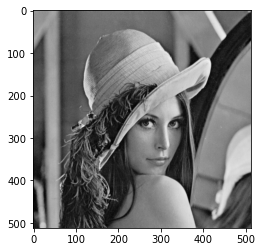

In [51]:
plt.imshow(lenna, cmap="gray")
plt.savefig('lenna_orig.png')

In [52]:
lenna.shape

(512, 512)

(1) Singular Value Decomposition (SVD)

k = 107


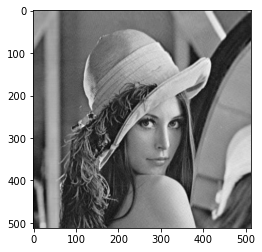

In [53]:
# Use the SVD function to compute SVD of the image
u, s, vh = np.linalg.svd(lenna, full_matrices=True)
r, c = lenna.shape
# Generate a rank-k approximation image
img = np.zeros((r, c))
uh = np.array(u).T
k = 0

for i in range(0, r):
    if s[i]/s[0] >= 0.005:
        img = np.add(img, np.matmul(np.array([uh[i]]).T, np.array([vh[i]])) * s[i])
        k = i+1
    else:
        break
    
print(f'k = {k}')
plt.imshow(img, cmap="gray")
# plt.savefig('lenna_auto_{k}.png')

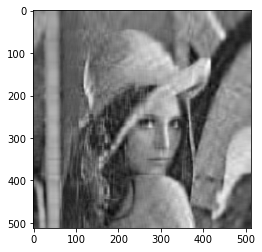

In [5]:
# Use the SVD function to compute SVD of the image
u, s, vh = np.linalg.svd(lenna, full_matrices=True)
r, c = lenna.shape
# Generate a rank-k approximation image
img = np.zeros((r, c))
uh = np.array(u).T
k = 20

for i in range(0, k):
    img = np.add(img, np.matmul(np.array([uh[i]]).T, np.array([vh[i]])) * s[i])

plt.imshow(img, cmap="gray")
# plt.savefig(f'lenna_{k}.png')

(2) Discrete Fourier Transform (DFT)

In [43]:
# FFT functions
# 1d FFT functions
def omega(p, q):
   '''The omega term in DFT formula'''
   return cmath.exp((2.0 * cmath.pi * 1j * q) / p)
def pad(lst):
   '''padding the list to next nearest power of 2 as FFT implemented is radix 2'''
   k = 0
   while 2**k < len(lst):
      k += 1
   return np.concatenate((lst, ([0] * (2 ** k - len(lst)))))
def fft(x):
   '''FFT of 1d signals'''
   n = len(x)
   if n == 1:
      return x
   Feven, Fodd = fft(x[0::2]), fft(x[1::2])
   combined = [0] * n
   for m in range(int(n/2)):
     combined[m] = Feven[m] + omega(n, -m) * Fodd[m]
     combined[m + int(n/2)] = Feven[m] - omega(n, -m) * Fodd[m]
   return combined
def ifft(X):
   '''Inverse FFT of 1d signals'''
   x = fft([x.conjugate() for x in X])
   return [x.conjugate()/len(X) for x in x]
# 2d FFT functions
def pad2(x):
   m, n = np.shape(x)
   M, N = 2 ** int(math.ceil(math.log(m, 2))), 2 ** int(math.ceil(math.log(n, 2)))
   F = np.zeros((M,N), dtype = x.dtype)
   F[0:m, 0:n] = x
   return F, m, n
def fft2(f):
   '''FFT of 2d images
   usage X, m, n = fft2(x), where m and n are dimensions of original signal'''
   f, m, n = pad2(f)
   return np.transpose(fft(np.transpose(fft(f)))), m, n
def ifft2(F, m, n):
   '''Inverse FFT of 2d images'''
   f, M, N = fft2(np.conj(F))
   f = np.matrix(np.real(np.conj(f)))/(M*N)
   return f[0:m, 0:n]

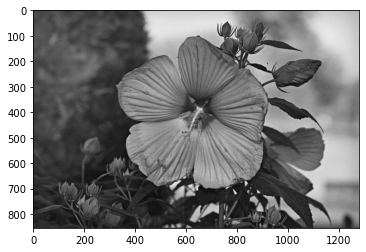

In [19]:
A, m, n = fft2(hibiscus)
# Compute the norm of each entry in DFT matrix A
norm_A = np.real(np.sqrt(np.multiply(np.conjugate(A), A)))
# Remove the least 100k percent Fourier coefficients
k = 0.1  # k is a value we can shoose
max = np.amax(norm_A)
r, c = norm_A.shape
cnt = int(k * r * c)
# Descending order of all norms of entries in Fourier coefficients matrix
stacked_norm_A = pd.DataFrame(np.reshape(norm_A, r * c).transpose(), columns=['values'])
sorted_norm_A = stacked_norm_A.sort_values(by=['values'], ascending=False).reset_index(drop=True)
# Pick out the bounded value nmax which is the boundary value of top 100k largest value 
# of all norms of entries in A
nmax = sorted_norm_A['values'][cnt]
# Assign 0 to values less than nmax
A = np.where(norm_A < nmax, 0, A)
# Calculate iDFT
img = ifft2(A, m, n)
plt.imshow(img, cmap="gray")
plt.savefig(f'hibiscus_fft_{k}.png')

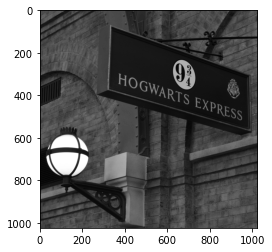

In [9]:
plt.imshow(platform, cmap="gray")
plt.savefig('platform_orig')

(3) Haar Transform

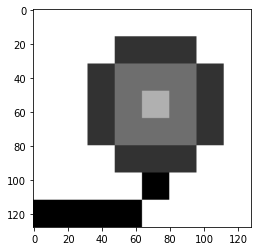

In [50]:
plt.imshow(balloon, cmap="gray")
plt.savefig(f'balloon_orig.png')

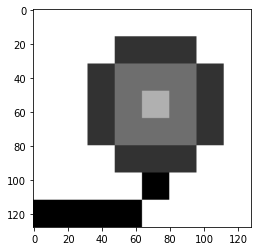

In [55]:
h, w = balloon.shape
# Construct the Haar matrix
H = np.zeros((h, w))
H[0, :] = 1
H[1, 0:int(w/2)] = 1
H[1, int(w/2):(w+1)] = -1
for i in range(2, h):
    for j in range(0, w):
        p = math.floor(math.log(i, 2))
        n = i - pow(2, p)
        t = j/w
        if n/pow(2, p) <= t and t < (n+0.5)/pow(2, p):
            H[i][j] = pow(math.sqrt(2), p)
        elif (n+0.5)/pow(2, p) <= t and t < (n+1)/pow(2, p):
            H[i][j] = -pow(math.sqrt(2), p)
H = np.true_divide(H, math.sqrt(h))
Ht = H.transpose()
# Compute the Haar coefficients matrix
G = np.matmul(np.matmul(H, balloon), Ht)
# Generate the approximation of the image using only the coefficients in the upper left corner
img = np.zeros((h, w))
k = 10
for i in range(0,k):
    for j in range(0, k):
        img = np.add(img, np.matmul(np.array([H[i]]).T, np.array([H[j]])) * G[i][j])
plt.imshow(img, cmap="gray")
plt.savefig(f'balloon_HaarTo_{k}.png')

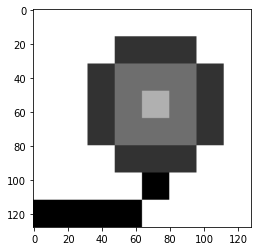

In [32]:
recon = np.matmul(np.matmul(Ht, G), H)
plt.imshow(recon, cmap="gray")
plt.savefig(f'balloon_Haar.png')

ERROR ANALYSIS

In [18]:
balloon = skio.imread('balloon.png')

7.189451393704807e-22
4.388092891665532e-26


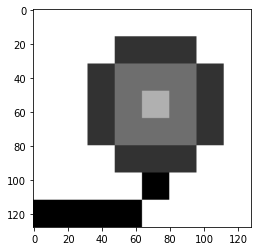

In [25]:
# SVD
# Use the SVD function to compute SVD of the image
u, s, vh = np.linalg.svd(balloon, full_matrices=True)
r, c = balloon.shape
# Generate a rank-k approximation image
img = np.zeros((r, c))
uh = np.array(u).T
k = 5

for i in range(0, k):
    img = np.add(img, np.matmul(np.array([uh[i]]).T, np.array([vh[i]])) * s[i])

error = 0
for j in range(k, r):
    error = error + pow(s[j], 2)

print(error)
print(error/pow(r, 2))

plt.imshow(img, cmap="gray")

In [42]:
h, w = balloon.shape
# Construct the Haar matrix
H = np.zeros((h, w))
H[0, :] = 1
H[1, 0:int(w/2)] = 1
H[1, int(w/2):(w+1)] = -1
for i in range(2, h):
    for j in range(0, w):
        p = math.floor(math.log(i, 2))
        n = i - pow(2, p)
        t = j/w
        if n/pow(2, p) <= t and t < (n+0.5)/pow(2, p):
            H[i][j] = pow(math.sqrt(2), p)
        elif (n+0.5)/pow(2, p) <= t and t < (n+1)/pow(2, p):
            H[i][j] = -pow(math.sqrt(2), p)
H = np.true_divide(H, math.sqrt(h))
Ht = H.transpose()
# Compute the Haar coefficients matrix
G = np.matmul(np.matmul(H, balloon), Ht)
# Generate the approximation of the image using only the coefficients in the upper left corner
img = np.zeros((h, w))
k = 8
for i in range(0,k):
    for j in range(0, k):
        img = np.add(img, np.matmul(np.array([H[i]]).T, np.array([H[j]])) * G[i][j])
error_mat = np.subtract(img, balloon)
error = np.sum(np.multiply(error_mat, error_mat))
print(error)
print(error/pow(h,2))

5.730293693461099e-22
3.497493709387878e-26


In [44]:
#DFT
A, m, n = fft2(balloon)
norm_A = np.real(np.sqrt(np.multiply(np.conjugate(A), A)))
k = 0.01  # k is a value we can shoose
max = np.amax(norm_A)
r, c = norm_A.shape
cnt = int(k * r * c)

stacked_norm_A = pd.DataFrame(np.reshape(norm_A, r * c).transpose(), columns=['values'])
sorted_norm_A = stacked_norm_A.sort_values(by=['values'], ascending=False).reset_index(drop=True)

nmax = sorted_norm_A['values'][cnt]
# Assign 0 to values less than nmax
A = np.where(norm_A < nmax, 0, A)
# Calculate iDFT
img = ifft2(A, m, n)

error_mat = np.subtract(img, balloon)
error = np.sum(np.multiply(error_mat, error_mat))
print(error)
print(error/pow(m,2))

12927986.99988463
789.0617065359271


In [52]:
#DFT
A, m, n = fft2(balloon)
k = 0
for i in range(k,m):
    A[:, i] = 0
try_img = ifft2(A, m, n)
error_mat = np.subtract(try_img, balloon)
error = np.sum(np.multiply(error_mat, error_mat))
print(error)
print(error/pow(m,2))

[[ 3.09657600e+06     +0.j          4.36941609e+05 -28452.6756384j
   2.83600610e+04 -25704.06100598j ... -1.57581122e+04 -71477.06837534j
   2.83600610e+04 +25704.06100598j  4.36941609e+05 +28452.6756384j ]
 [ 1.64582922e+05 +31078.87750687j -1.84025222e+05+155854.706801j
  -1.71409582e+05 +20312.43851451j ... -1.13225444e+04 +23191.10931607j
  -3.70157056e+04-168593.23068497j -6.08681280e+04-188254.25721189j]
 [-3.80261226e+04-116460.30618193j -2.38683273e+05 +66247.0087441j
   1.34414159e+05 -32044.35011604j ... -9.75280624e+03 -38640.13191207j
   4.50649393e+04+130626.02207193j -1.66845485e+03-195941.30374791j]
 ...
 [-3.80124355e+04+213358.18776287j  7.42977125e+04 +33886.25601559j
   1.14060568e+04 -42796.21804849j ... -5.79814775e+04 -30197.2306076j
   4.37081316e+04  +7156.37058653j -1.26319392e+05 -55167.58473083j]
 [-3.80261226e+04+116460.30618193j -1.66845485e+03+195941.30374791j
   4.50649393e+04-130626.02207193j ... -1.65488166e+04 -62207.84129606j
   1.34414159e+05 +32044

In [48]:
print(A.shape)

(128, 128)
